# Modelling

### Essential Libraries

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  
> SciPy: Library for Scientific Computing and Technical Computing  
> Sklearn : Machine Learning and Statistical Modeling

In [51]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
sb.set() # set the default Seaborn style for graphics
pd. set_option('display.max_columns', None)

### Importing the dataset

In [52]:
#Import Dataset
heart_data = pd.read_csv('Dataset/heart.csv')
heart_data.head(100)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,58,M,ASY,130,263,0,Normal,140,Y,2.0,Flat,1
96,43,M,ATA,142,207,0,Normal,138,N,0.0,Up,0
97,39,M,NAP,160,147,1,Normal,160,N,0.0,Up,0
98,56,M,ASY,120,85,0,Normal,140,N,0.0,Up,0


In [53]:
#remove duplicates
heart_data = heart_data.drop_duplicates()
cols = ['FastingBS','HeartDisease']
heart_data[cols] = heart_data[cols].astype('object') #changing type of column as FastingBS and HeartDisease only consists of 1's and 0's 

After Dataset is cleaned, there are 918 Rows and 12 Columns and there are no NULL values in any Row of the data. 

In [54]:
#Removing outliers outside of IQR
def remove_outliers_IQR(df,colName):
    q1=df[colName].quantile(0.25)
    q3=df[colName].quantile(0.75)
    IQR=q3-q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    outliers = df[(df[colName] < lower_bound) | (df[colName] > upper_bound)]
    df_no_outliers = df.drop(outliers.index)
    return df_no_outliers

### One-hot encoding the categorical variables

For ease of use of categorical data in calculating correlations and modelling, we converted all our ‘object’ type data to ‘categorical’ type and represented categorical variables as numerical values.

In [55]:
heart_encoded = heart_data.copy()
cat_variables = ['Sex','ChestPainType','RestingECG','ST_Slope','FastingBS','ExerciseAngina']

# Apply numeric encoding
label_encoders = {}
encoding_mapping= {}
for col in cat_variables:
    label_encoders[col] = LabelEncoder()
    heart_encoded[col] = label_encoders[col].fit_transform(heart_encoded[col])
    encoding_mapping[col] = dict(zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_)))
    heart_encoded[col] = heart_encoded[col].astype('category')
    
# Display the encoding mapping
print("Encoding Mapping:")
for col, mapping in encoding_mapping.items():
    print(f"{col}: {mapping}")

Encoding Mapping:
Sex: {'F': 0, 'M': 1}
ChestPainType: {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
RestingECG: {'LVH': 0, 'Normal': 1, 'ST': 2}
ST_Slope: {'Down': 0, 'Flat': 1, 'Up': 2}
FastingBS: {0: 0, 1: 1}
ExerciseAngina: {'N': 0, 'Y': 1}


In [56]:
heart_encoded['HeartDisease'] = heart_encoded['HeartDisease'].astype('category')
heart_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(7), float64(1), int64(4)
memory usage: 43.2 KB


### Extract the categorical variables

In [57]:
heartcategorical = heart_encoded.select_dtypes(include=['category'])
heartcategorical

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
0,1,1,0,1,0,2,0
1,0,2,0,1,0,1,1
2,1,1,0,2,0,2,0
3,0,0,0,1,1,1,1
4,1,2,0,1,0,2,0
...,...,...,...,...,...,...,...
913,1,3,0,1,0,1,1
914,1,0,1,1,0,1,1
915,1,0,0,1,1,1,1
916,0,1,0,0,0,1,1


## 1. Decision Tree Classifier

A Decision Tree Classifier is a supervised machine learning method employed to tackle classification and regression problems.

We will be using a Decision Tree Classifer to model our predictors to find their effectiveness in predicting the onset of heart disease.

We first split the data into a 75:25 train-test split.

In [58]:
features = [x for x in heart_encoded.columns if x not in 'HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(heart_encoded[features], heart_encoded['HeartDisease'], train_size = 0.75, random_state = 1)
print(f'train samples: {len(X_train)}')
print(f'test samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 688
test samples: 230
target proportion: 0.5334


In [59]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700]
max_depth_list = [1, 2, 3, 4, 8, 16, 32, 64, None]

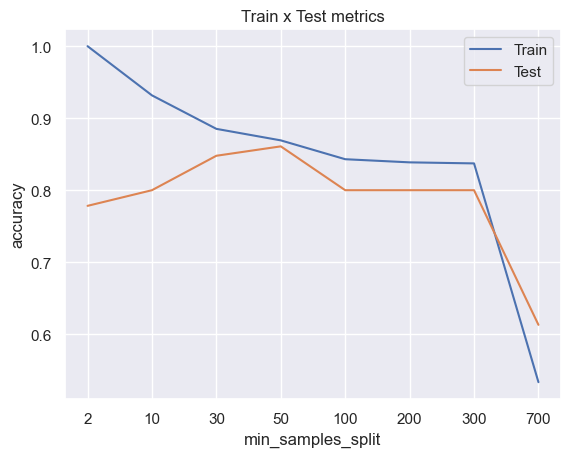

In [60]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split, random_state = 1).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_test)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks= range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Test'])

Note how increasing the number of min_samples_split reduces overfitting.

Increasing min_samples_split from 10 to 30, and from 30 to 50, even though it does not improve the Test accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

Let's do the same experiment with max_depth

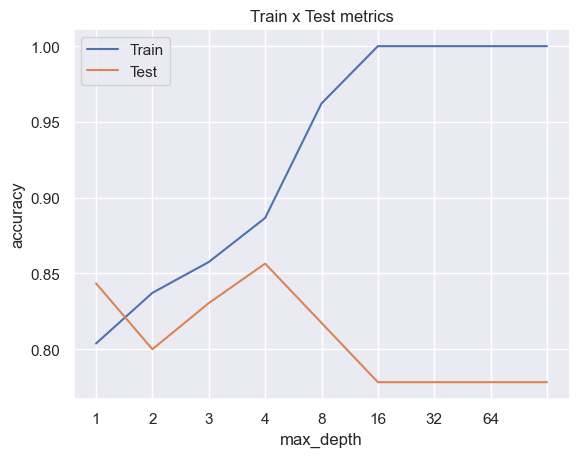

In [61]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 1).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Test'])

We can see that in general, reducing max_depth can help to reduce overfitting.

Reducing max_depth from 8 to 4 increases test accuracy closer to training accuracy, while significantly reducing training accuracy. The validation accuracy reaches the highest at max_depth=4. When the max_depth is smaller than 3, both training and test accuracy decreases. The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). When the max_depth is too high ( >= 5), test accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

In [62]:
def classificationtree(X,y,df,depth):
    X = df[X]
    y = df[y]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.25)
    
    #Creating the decision tree model
    dectree = DecisionTreeClassifier(min_samples_split = 50, max_depth = 3, random_state = 1).fit(X_train,y_train)
    
    
    importances = dectree.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(X_train.shape[1]):
        print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")
    feature_names = X.columns.tolist()
    
    #Plotting the decision tree
    f = plt.figure(figsize=(20,20))
    plot_tree(dectree, filled=True, rounded=True, feature_names= feature_names, class_names=["No","Yes"])
    
    # Predict predictors corresponding to HeartDiseaseTrain (X_train)
    f, axes = plt.subplots(1,figsize=(8, 8))
    train_pred = dectree.predict(X_train)
    print("Train Classification Accuracy \t:", dectree.score(X_train, y_train))
    sb.heatmap(confusion_matrix(y_train, train_pred),annot=True,fmt=".0f",annot_kws={"size":18})

    # Predict Predictors corresponding to HeartDiseaseTest (X_test)
    f, axes = plt.subplots(figsize=(4, 4))
    test_pred = dectree.predict(X_test)
    print("Test Classification Accuracy \t:", dectree.score(X_test,y_test))
    sb.heatmap(confusion_matrix(y_test,test_pred),annot=True,fmt=".0f",annot_kws={"size": 18})
    
    print("\n")
    
    # print classification metric
    [TPR_train, FPR_train, FNR_train] = binary_metric(y_train,train_pred)
    [TPR_test, FPR_test, FNR_test] = binary_metric(y_test,test_pred)
    print("True Positive Rate for train\t:", TPR_train)
    print("False Positive Rate for train\t:", FPR_train)
    print("False Negative Rate for train\t:", FNR_train)
    print("True Positive Rate for test\t:", [TPR_test, FPR_test][0])
    print("False Positive Rate for test\t:", [TPR_test, FPR_test][1])
    print("False Negative Rate for test\t:", [TPR_test, FPR_test][1])

    
def binary_metric(y_true, y_pred):
    CM = confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    return TPR, FPR, FNR

Feature ranking:
1. Feature 10 (0.6567491064467468)
2. Feature 4 (0.14567620965687508)
3. Feature 7 (0.08946832115435346)
4. Feature 2 (0.07299358138055857)
5. Feature 1 (0.035112781361466075)
6. Feature 9 (0.0)
7. Feature 8 (0.0)
8. Feature 6 (0.0)
9. Feature 5 (0.0)
10. Feature 3 (0.0)
11. Feature 0 (0.0)
Train Classification Accuracy 	: 0.8546511627906976
Test Classification Accuracy 	: 0.8347826086956521


True Positive Rate for train	: 0.8801089918256131
False Positive Rate for train	: 0.17445482866043613
False Negative Rate for train	: 0.11989100817438691
True Positive Rate for test	: 0.851063829787234
False Positive Rate for test	: 0.19101123595505617
False Negative Rate for test	: 0.19101123595505617


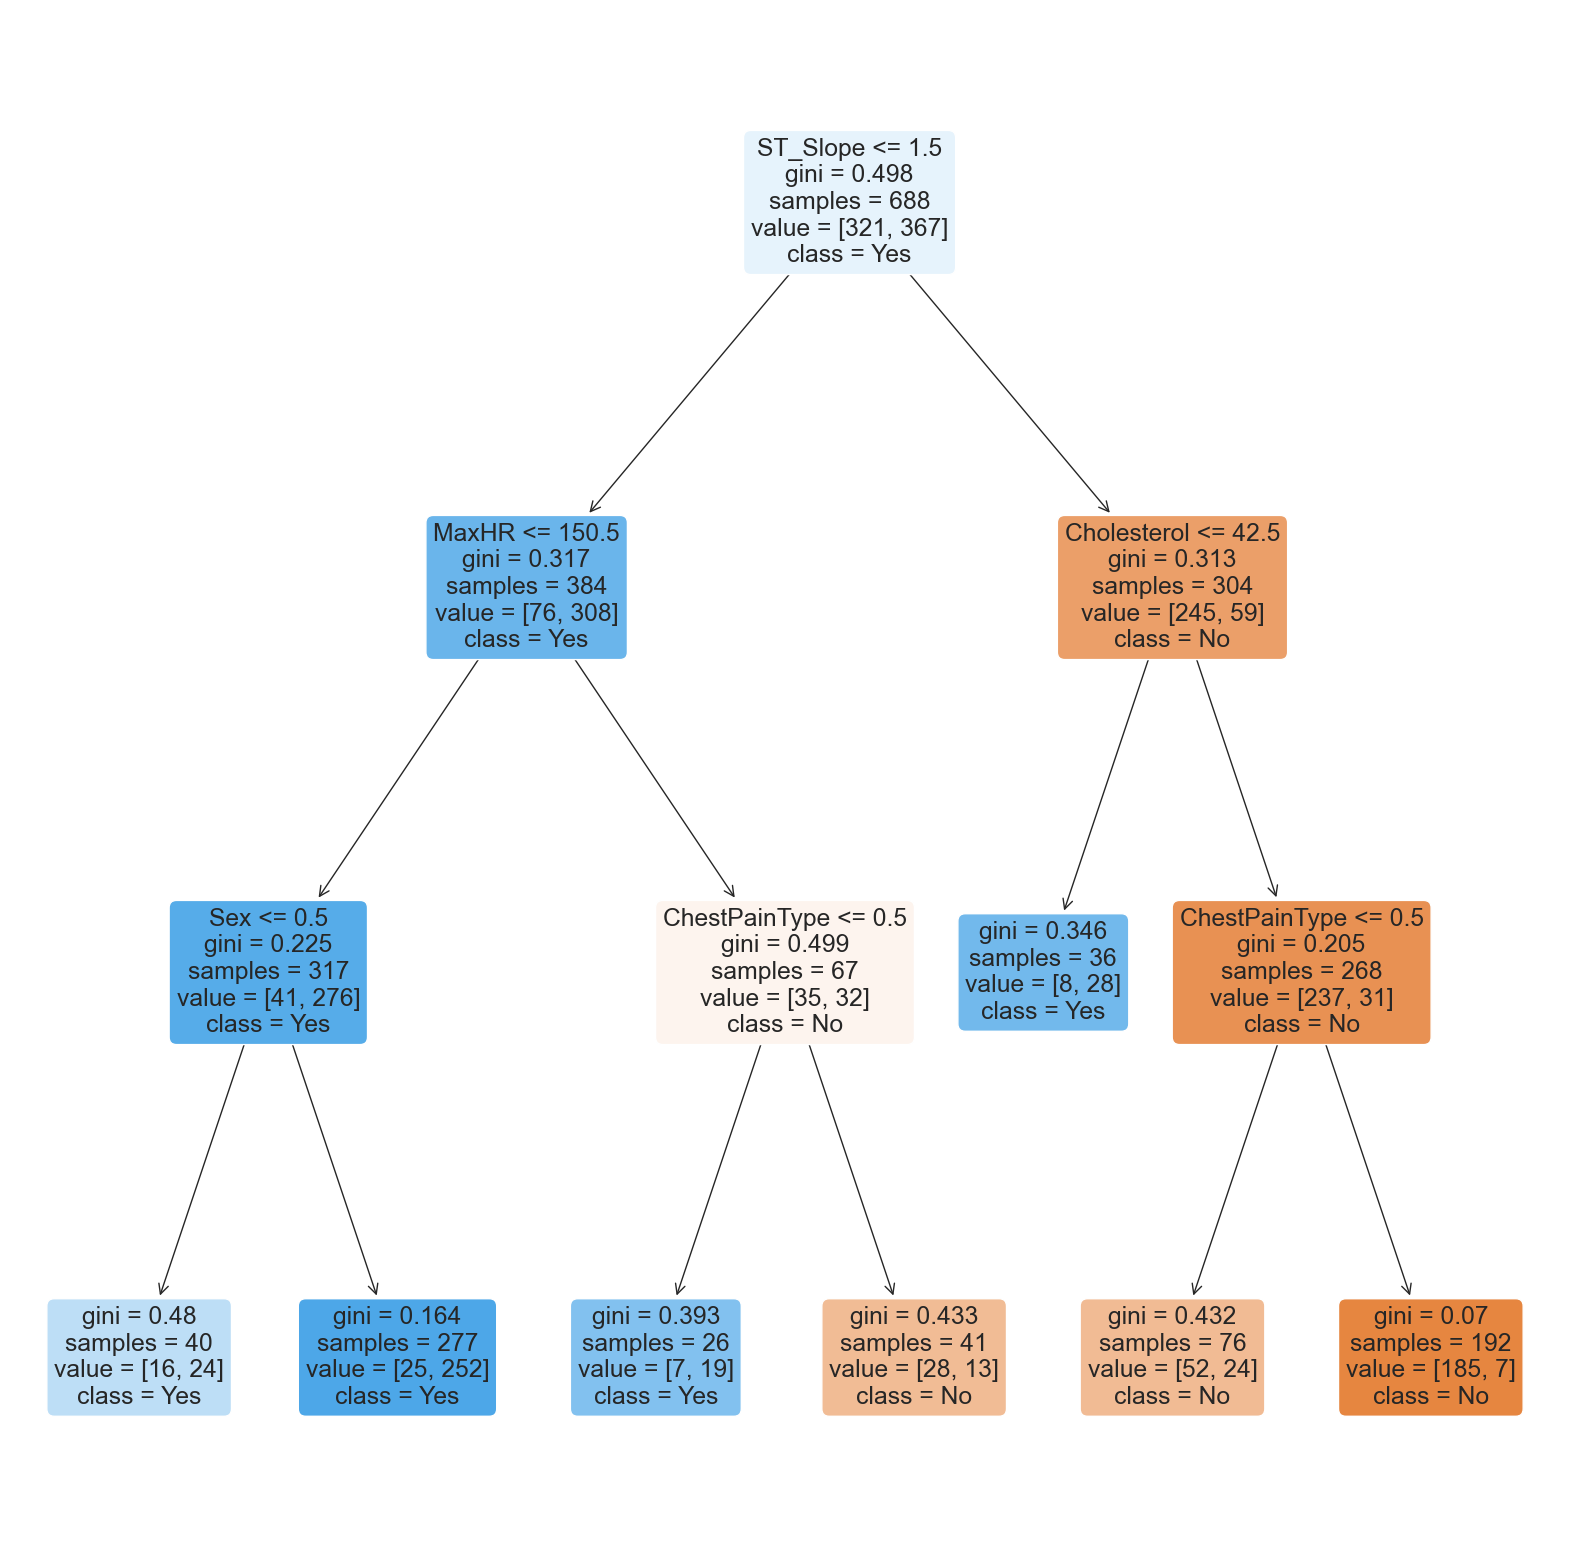

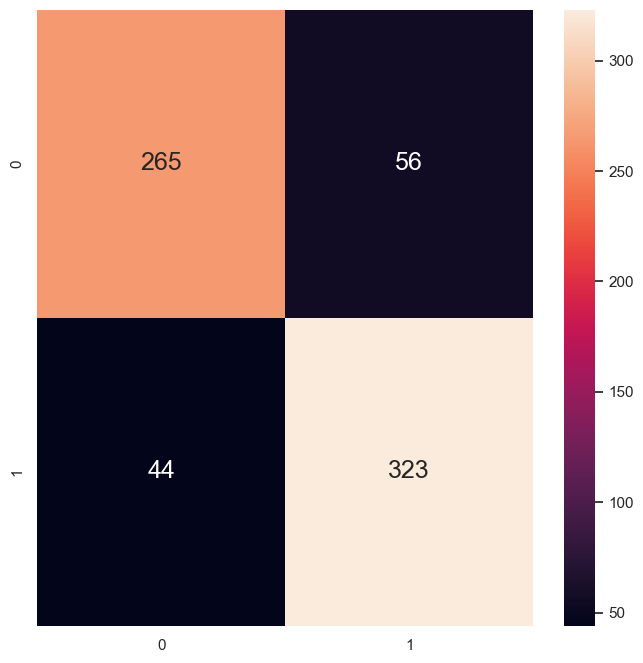

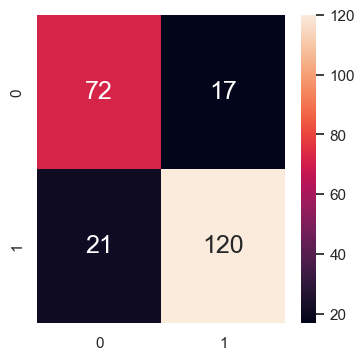

In [63]:
features = [x for x in heart_encoded.columns if x not in 'HeartDisease']
classificationtree(X=features, y = 'HeartDisease', df = heart_encoded, depth = 3)

Feature ranking:
1. Feature 2 (0.5993862400559374)
2. Feature 0 (0.31360251354498314)
3. Feature 1 (0.08701124639907934)
Train Classification Accuracy 	: 0.7543604651162791
Test Classification Accuracy 	: 0.782608695652174


True Positive Rate for train	: 0.7520435967302452
False Positive Rate for train	: 0.24299065420560748
False Negative Rate for train	: 0.24795640326975477
True Positive Rate for test	: 0.8226950354609929
False Positive Rate for test	: 0.2808988764044944
False Negative Rate for test	: 0.2808988764044944


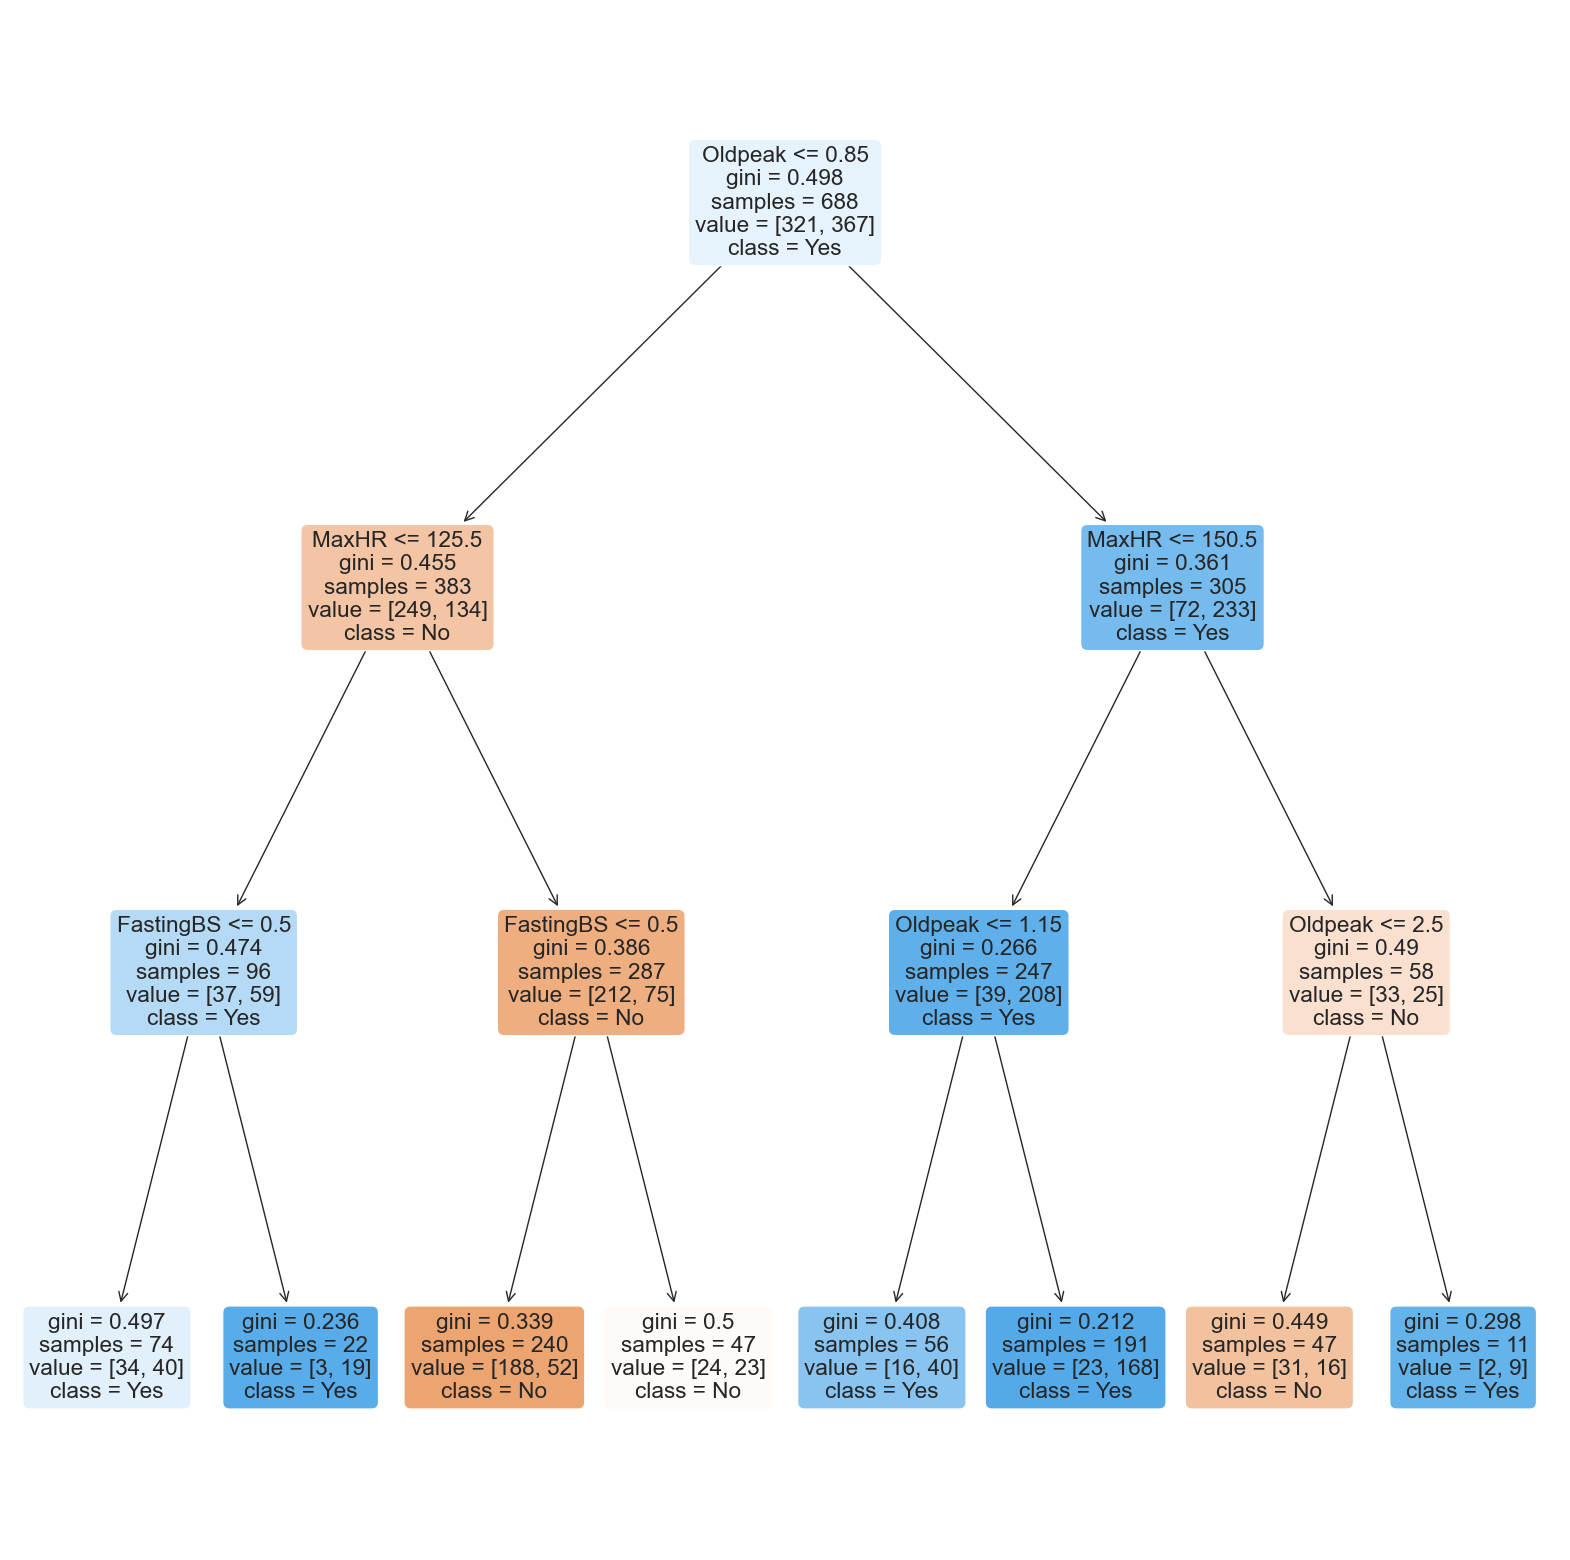

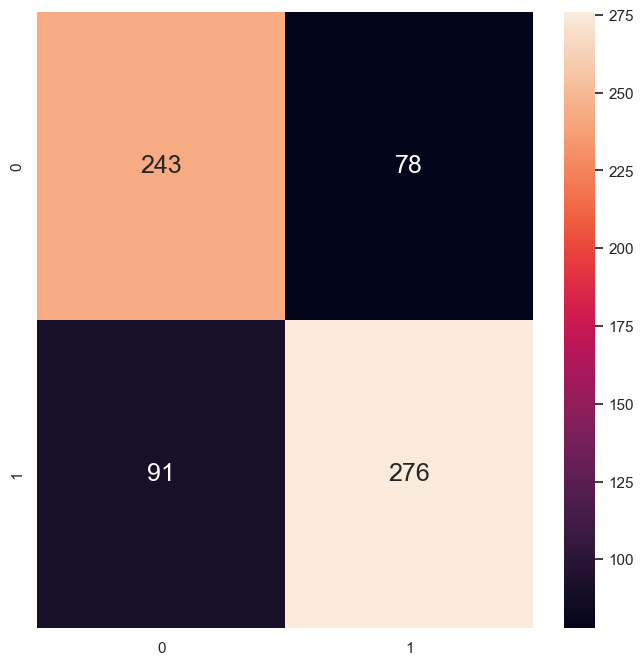

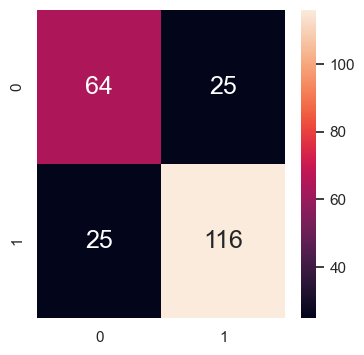

In [64]:
features = ['MaxHR', 'FastingBS', 'Oldpeak']
classificationtree(X=features, y = 'HeartDisease', df = heart_encoded, depth = 3)

Feature ranking:
1. Feature 2 (0.4965316744313573)
2. Feature 1 (0.369518394793353)
3. Feature 0 (0.13394993077528966)
Train Classification Accuracy 	: 0.8008720930232558
Test Classification Accuracy 	: 0.8


True Positive Rate for train	: 0.7574931880108992
False Positive Rate for train	: 0.14953271028037382
False Negative Rate for train	: 0.24250681198910082
True Positive Rate for test	: 0.7801418439716312
False Positive Rate for test	: 0.16853932584269662
False Negative Rate for test	: 0.16853932584269662


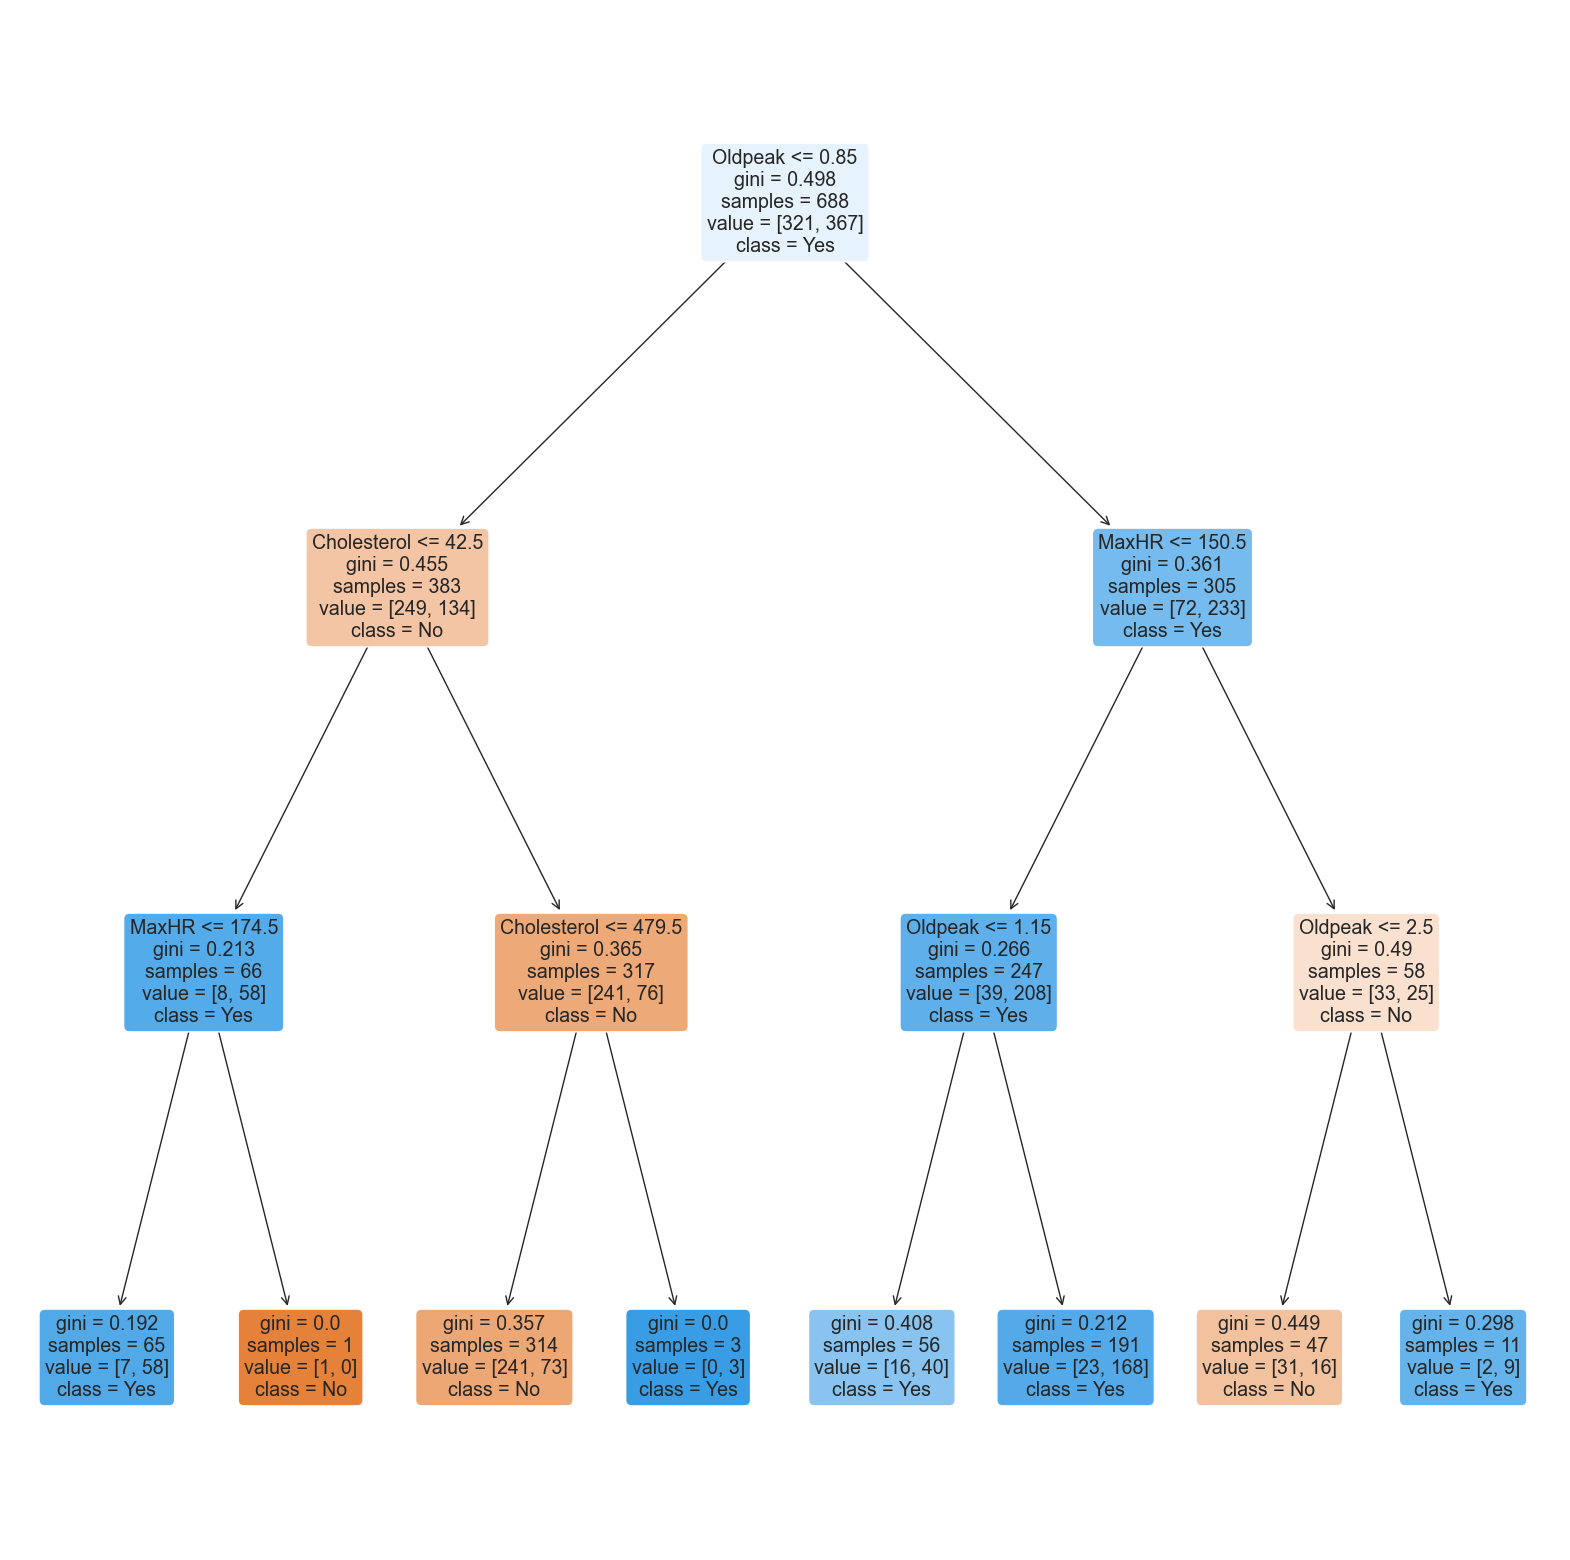

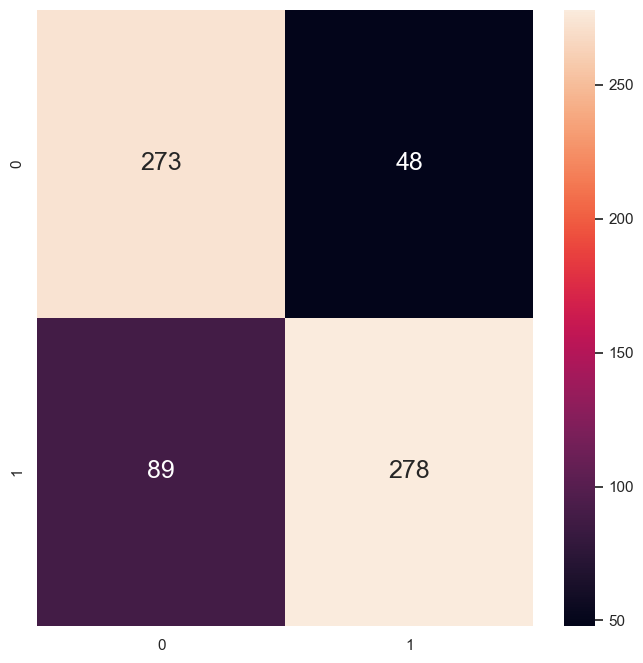

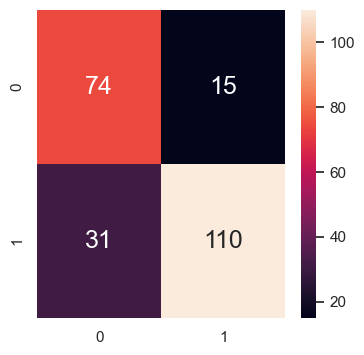

In [65]:
features = ['MaxHR', 'Cholesterol', 'Oldpeak']
classificationtree(X=features, y = 'HeartDisease', df = heart_encoded, depth = 3)

## 2. K-Nearest Neighbours (KNN) Classifier

5 models will be created using KNeighborsClassifier(K-Nearest Neighbors), including:
1. All categorical variables
2. Top 3 categorical variables based on Chi-squared value + P-value
3. Top 3 individual categorical variables based on Chi-squared value + P-value (3 Models)

The k-nearest neighbors (KNN) algorithm is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. It is one of the popular and simplest classification and regression classifiers used in machine learning today.

In [66]:
#Fixed neighbours of 5
def knnClassifier(data,X,y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize K-Nearest Neighbors classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=5)

    # Train the classifier
    knn_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_train_pred = knn_classifier.predict(X_train)
    y_test_pred = knn_classifier.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", knn_classifier.score(X_train, y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", knn_classifier.score(X_test, y_test))
    print()
    
    
    
    # Create confusion matrix for Train and Test
    f, axes = plt.subplots(2, 2, figsize=(12, 4))
    cfMTrain = confusion_matrix(y_train, y_train_pred)
    cfMTest = confusion_matrix(y_test, y_test_pred)
    
    # Calculate TP, TN, FP, FN from the confusion matrix
    TP = cfMTrain[1, 1]  # True Positives
    TN = cfMTrain[0, 0]  # True Negatives
    FP = cfMTrain[0, 1]  # False Positives
    FN = cfMTrain[1, 0]  # False Negatives
    # Calculate True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR), False Negative Rate (FNR)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = 1 - TNR
    FNR = 1 - TPR

    # Print the rates
    print("Train Data: ")
    print("True Positive Rate (TPR): ",TPR)
    print("True Negative Rate (TNR): ",TNR)
    print("False Positive Rate (FPR): ",FPR)
    print("False Negative Rate (FNR): ",FNR)
    
    # Calculate TP, TN, FP, FN from the confusion matrix
    TP = cfMTest[1, 1]  # True Positives
    TN = cfMTest[0, 0]  # True Negatives
    FP = cfMTest[0, 1]  # False Positives
    FN = cfMTest[1, 0]  # False Negatives
    # Calculate True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR), False Negative Rate (FNR)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = 1 - TNR
    FNR = 1 - TPR

    # Print the rates
    print("\nTest Data: ")
    print("True Positive Rate (TPR): ",TPR)
    print("True Negative Rate (TNR): ",TNR)
    print("False Positive Rate (FPR): ",FPR)
    print("False Negative Rate (FNR): ",FNR)
    
    sb.heatmap(cfMTrain, annot = True, fmt=".0f",cmap="Blues", annot_kws={"size": 18}, ax = axes[0,0])
    sb.heatmap(cfMTrain/np.sum(cfMTrain), annot = True, fmt=".2%",cmap="Blues", annot_kws={"size": 18}, ax = axes[0,1])
    
    sb.heatmap(cfMTest, annot = True, fmt=".0f",cmap="Blues", annot_kws={"size": 18}, ax = axes[1,0])
    sb.heatmap(cfMTest/np.sum(cfMTest), annot = True, fmt=".2%",cmap="Blues", annot_kws={"size": 18}, ax = axes[1,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.show()



Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8760217983651226

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8641304347826086

Train Data: 
True Positive Rate (TPR):  0.9177057356608479
True Negative Rate (TNR):  0.8258258258258259
False Positive Rate (FPR):  0.17417417417417413
False Negative Rate (FNR):  0.0822942643391521

Test Data: 
True Positive Rate (TPR):  0.8598130841121495
True Negative Rate (TNR):  0.8701298701298701
False Positive Rate (FPR):  0.1298701298701299
False Negative Rate (FNR):  0.14018691588785048


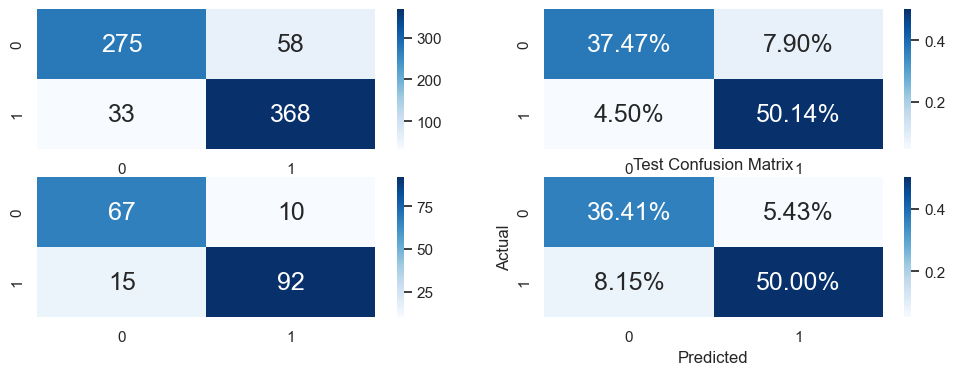

In [67]:
X = heartcategorical[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
y = heartcategorical['HeartDisease']
knn_model_1 = knnClassifier(heartcategorical,X, y)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8419618528610354

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8206521739130435

Train Data: 
True Positive Rate (TPR):  0.8827930174563591
True Negative Rate (TNR):  0.7927927927927928
False Positive Rate (FPR):  0.2072072072072072
False Negative Rate (FNR):  0.11720698254364093

Test Data: 
True Positive Rate (TPR):  0.7663551401869159
True Negative Rate (TNR):  0.8961038961038961
False Positive Rate (FPR):  0.10389610389610393
False Negative Rate (FNR):  0.23364485981308414


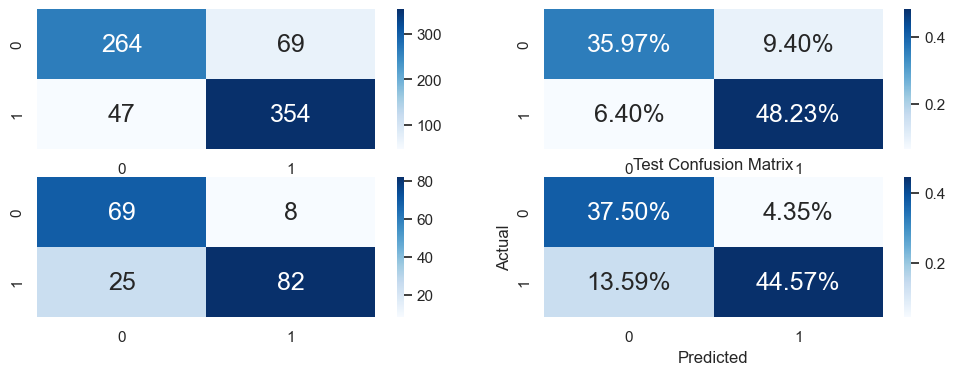

In [68]:
X = heartcategorical[['ChestPainType','ExerciseAngina','ST_Slope']]

knn_model_2 = knnClassifier(heartcategorical,X, y)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.782016348773842

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.75

Train Data: 
True Positive Rate (TPR):  0.773067331670823
True Negative Rate (TNR):  0.7927927927927928
False Positive Rate (FPR):  0.2072072072072072
False Negative Rate (FNR):  0.22693266832917702

Test Data: 
True Positive Rate (TPR):  0.6635514018691588
True Negative Rate (TNR):  0.8701298701298701
False Positive Rate (FPR):  0.1298701298701299
False Negative Rate (FNR):  0.33644859813084116


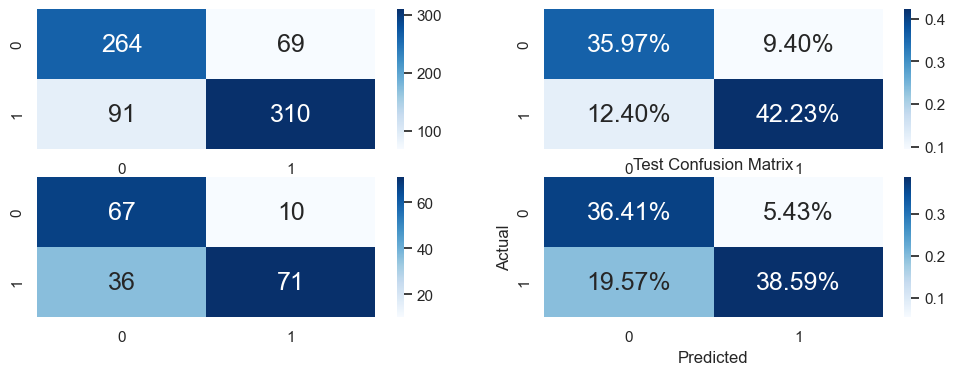

In [69]:
X = heartcategorical[['ST_Slope']]

knn_model_3 = knnClassifier(heartcategorical,X, y)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7438692098092643

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7934782608695652

Train Data: 
True Positive Rate (TPR):  0.8054862842892768
True Negative Rate (TNR):  0.6696696696696697
False Positive Rate (FPR):  0.3303303303303303
False Negative Rate (FNR):  0.19451371571072318

Test Data: 
True Positive Rate (TPR):  0.8317757009345794
True Negative Rate (TNR):  0.7402597402597403
False Positive Rate (FPR):  0.2597402597402597
False Negative Rate (FNR):  0.16822429906542058


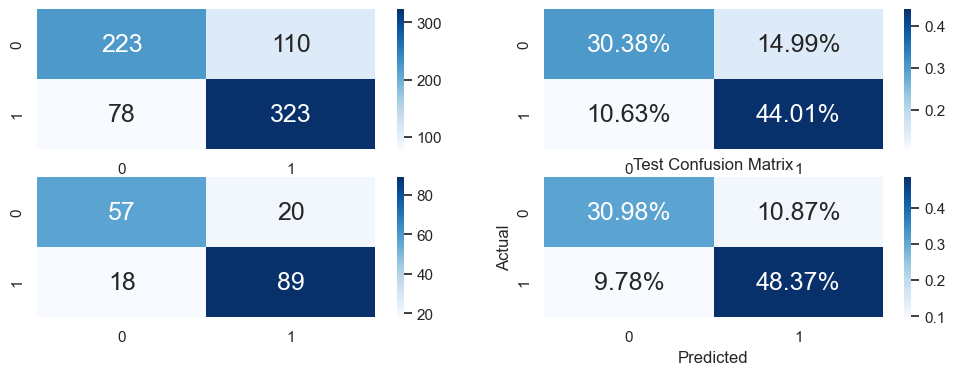

In [70]:
X = heartcategorical[['ChestPainType']]

knn_model_4 = knnClassifier(heartcategorical,X, y)

Although model 4 have lower train and test accuracy, it also has lower false negative rate on test confusion matrix compared to model 3. In this dataset problem, i would choose model 4 instead of model 3.

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7493188010899182

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.657608695652174

Train Data: 
True Positive Rate (TPR):  0.6483790523690773
True Negative Rate (TNR):  0.8708708708708709
False Positive Rate (FPR):  0.1291291291291291
False Negative Rate (FNR):  0.35162094763092266

Test Data: 
True Positive Rate (TPR):  0.5233644859813084
True Negative Rate (TNR):  0.8441558441558441
False Positive Rate (FPR):  0.1558441558441559
False Negative Rate (FNR):  0.47663551401869164


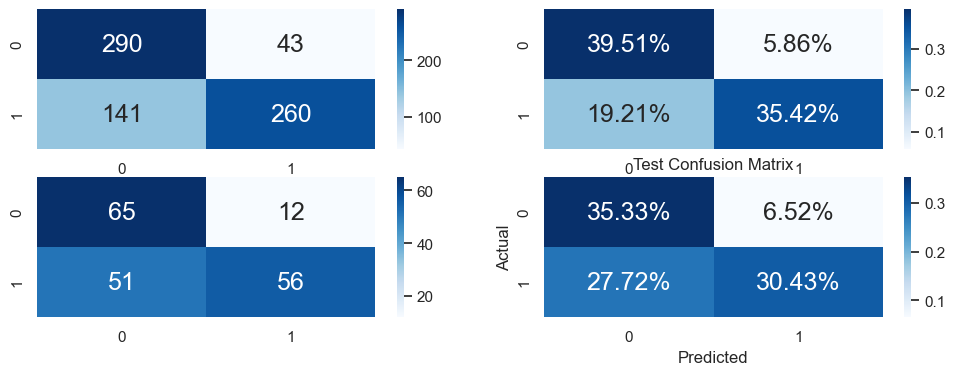

In [71]:
X = heartcategorical[['ExerciseAngina']]

knn_model_5 = knnClassifier(heartcategorical,X, y)

Model 5 have a lot of False negative which is very serious compared to False positive because in the case of detecting heart disease, it is better to be safe than sorry. Hence, we would want a lower number of false negative.

Top 5 models created (Descending Order):
> All variables: Has the highest train and test %. \
> Top 3 variables: Has the second highest train and test % \
> "ST_Slope" has higher train % but "ChestPainType" has higher test % \
> "ExerciseAngina" has the lowest %.

From this result, we can conclude that more variables being fed into the model yields a better result.
However, if comparing individuals result, more correlated should produce better results but this is not the case as "ST_Slope" has lower test % as compared to "ChestPainType". \
In other case, reducing the variables to the top 3 might yield better results as they have more data rows.

### Improvement

KNN is a non-parametric and lazy learning algorithm, which means it doesn't involve explicit training and instead relies on the entire training dataset during prediction.

Boosting algorithms like AdaBoost, Gradient Boosting, and XGBoost typically work with base estimators that are parametric and support sample weights.

Hence, due the the nature of KNN, it is not possible to implement boosting algorithm to improve the models. Applying it will return error from python.

In [72]:
from sklearn.ensemble import AdaBoostClassifier

def adaKNN(data,X,y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
    
    # Initialize a KNN base estimator
    base_estimator = KNeighborsClassifier(n_neighbors=5)

    # Initialize AdaBoost classifier with the KNN base estimator
    adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=43)

    # Train the AdaBoost classifier
    adaboost_clf=adaboost_clf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = adaboost_clf.predict(X_train)
    y_test_pred = adaboost_clf.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", adaboost_clf.score(X_train, y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", adaboost_clf.score(X_test, y_test))
    print()
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    sb.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
        
    print(adaboost_clf)



Use cross validation to evaluate the performance of a model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds. This process is repeated multiple times, each time using a different fold as the validation set. Finally, the results from each validation step are averaged to produce a more robust estimate of the model’s performance.

The main purpose of cross validation is to prevent overfitting, which occurs when a model is trained too well on the training data and performs poorly on new, unseen data. By evaluating the model on multiple validation sets, cross validation provides a more realistic estimate of the model’s generalization performance.<sup>[[1]](https://www.geeksforgeeks.org/cross-validation-machine-learning/)</sup>

In this case, we will be using k-fold cross validation.

k-neighbors:
[5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [73]:
def knnClassifier2(data,X,y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    n_neighbors_list= [5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    accuracy_list_train = []
    accuracy_list_val = []
    for n_neighbors in n_neighbors_list:
        model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_test)
        accuracy_train = accuracy_score(predictions_train, y_train)
        accuracy_val = accuracy_score(predictions_val, y_test)
        accuracy_list_train.append(accuracy_train)
        accuracy_list_val.append(accuracy_val)
    plt.title('Train x Test metrics')
    plt.xlabel('n_neighbors')
    plt.ylabel('accuracy')
    plt.xticks(ticks= range(len(n_neighbors_list)), labels=n_neighbors_list)
    plt.plot(accuracy_list_train)
    plt.plot(accuracy_list_val)
    plt.legend(['Train', 'Test'])
    plt.show()

    

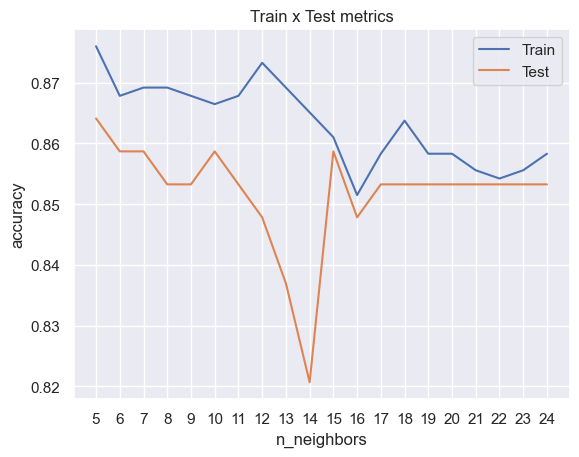

In [74]:
X = heartcategorical[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
y = heartcategorical['HeartDisease']
knn_model_1_2 = knnClassifier2(heartcategorical,X, y)

From this result, we can see that k-neighbours 7 and 9 has the highest test result. However k-neighbour 7 have higher a train result, but not overfitted. Hence, the model can be improve by using k-neighbours of 7 instead of 5.

## References
[1] A. Sharma, “Cross Validation in Machine Learning,” GeeksforGeeks, Nov. 21, 2017. https://www.geeksforgeeks.org/cross-validation-machine-learning/
‌